## 基礎建設

In [166]:
from datetime import datetime
import pandas as pd
import gzip, json
import numpy as np
import matplotlib.pyplot as plt
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [167]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [168]:
metadata = getDF('data/meta_All_Beauty.json.gz')
ratings = pd.read_csv('data/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [169]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [170]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [171]:
# rank
def take_number(row):
    if type(row) is list and len(row) > 0:
        return str(row[0]).replace(',', '')
    else:
        return 0

metadata['rank_num'] = pd.to_numeric(metadata['rank'].str.split().apply(lambda row: take_number(row)))
metadata['rank_num']

0        2938573
1         872854
2         956696
3        1870258
4          67701
          ...   
32887    2145325
32888    1639713
32889     207410
32890     965673
32891     478123
Name: rank_num, Length: 32892, dtype: int64

/var/folders/bg/xxg6qbpn4ll_hcgqp_vlb_wh0000gp/T/ipykernel_1951/1844010595.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  metadata['price_num'] = metadata['price'].str.replace('$', '').apply(lambda row: take_price_number(row))


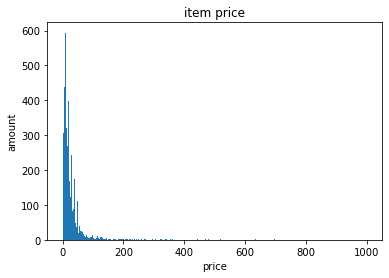

In [172]:
NO_PRICE = 9999999
def take_price_number(x):
    try:
        if type(x) is str and len(x) > 0:
            return float(x)
        else:
            return NO_PRICE
    except:
        return NO_PRICE
metadata['price_num'] = metadata['price'].str.replace('$', '').apply(lambda row: take_price_number(row))

plt.hist(metadata[metadata['price_num'] != NO_PRICE]['price_num'], bins=1000)
plt.title('item price')
plt.xlabel("price")
plt.ylabel("amount")
plt.show()

In [173]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')


## 資料切分

In [174]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())


In [175]:
# last bought
popular_metadata = metadata.merge(ratings_trainings, left_on='asin', right_on='asin')[['asin', 'DATE']]
popular_metadata = popular_metadata.groupby(by='asin').agg(date_list=('DATE', list)).reset_index()
def last_date(row):
    if type(row['date_list']) is list and len(row['date_list']) > 0:
        return max(row['date_list'])
    else:
        return datetime(1911, 1, 10, 10, 10)
popular_metadata['last'] = popular_metadata.apply(lambda row: last_date(row), axis=1)
popular_metadata = popular_metadata.set_index('asin')
popular_metadata
# popular_metadata.loc['B01HJEGTYK'].loc['last']

,date_list,last
asin,,
6546546450,"[2013-08-13 00:00:00, 2009-01-29 00:00:00]",2013-08-13
7178680776,[2017-10-06 00:00:00],2017-10-06
7250468162,[2017-08-26 00:00:00],2017-08-26
7367905066,[2017-04-12 00:00:00],2017-04-12
7414204790,"[2016-03-10 00:00:00, 2015-09-01 00:00:00, 201...",2018-03-02
...,...,...
B01HIWLLUK,[2016-09-24 00:00:00],2016-09-24
B01HJ1K3YK,[2017-04-21 00:00:00],2017-04-21
B01HJ84SGM,"[2018-03-23 00:00:00, 2017-10-03 00:00:00, 201...",2018-03-23


In [176]:
all_indexes_popular_metadata = popular_metadata.index.tolist()
def query_last_bought(row):
    if row['asin'] in all_indexes_popular_metadata:
        return popular_metadata.loc[row['asin']].loc['last']
    return datetime(1911, 1, 10, 10, 10)
metadata['last_bought'] = metadata.apply(lambda row: query_last_bought(row), axis=1)

In [177]:
def quarter(row):
  y = row['DATE'].strftime('%Y')
  m = row['DATE'].strftime('%m')
  if '01' <= m <= '03':
      q = '1'
  elif '04' <= m <= '06':
      q = '2'
  elif '07' <= m <= '09':
      q = '3'
  else:
      q = '4'
  return f'{y}-{q}'
ratings_trainings['YYYY-Q'] = ratings_trainings.apply(lambda row: quarter(row), axis=1)

/var/folders/bg/xxg6qbpn4ll_hcgqp_vlb_wh0000gp/T/ipykernel_1951/3849842929.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_trainings['YYYY-Q'] = ratings_trainings.apply(lambda row: quarter(row), axis=1)


## EDA

查使用者是不是很愛低價

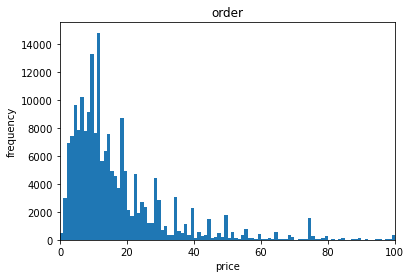

In [138]:
df = ratings_trainings.merge(metadata, left_on='asin', right_on='asin')[['reviewerID', 'asin', 'DATE', 'price_num']]
df = df[df['price_num'] != NO_PRICE]

plt.hist(df['price_num'], bins=1000)
plt.title('order')
plt.xlim([0, 100])
plt.xlabel("price")
plt.ylabel("frequency")
plt.show()

## 資料過濾
2014-3 - 2018-2 期間的評論人數大於 10000

In [139]:
ratings_trainings = ratings_trainings[ratings_trainings['YYYY-Q'] >= '2014-3']
ratings_trainings = ratings_trainings[ratings_trainings['YYYY-Q'] <= '2018-2']
ratings_trainings

,asin,reviewerID,overall,unixReviewTime,DATE,YYYY-Q
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000,2015-02-19,2015-1
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800,2014-12-18,2014-4
2,0143026860,A1572GUYS7DGSR,4.0,1407628800,2014-08-10,2014-3
7,014789302X,A26PO1B2Q2G1CS,1.0,1491782400,2017-04-10,2017-2
8,014789302X,AQ812VYVTC2RJ,5.0,1483401600,2017-01-03,2017-1
...,...,...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800,2017-07-20,2017-3
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400,2017-03-16,2017-1
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400,2017-03-01,2017-1
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200,2017-02-21,2017-1


## 產生推薦

In [178]:
import time
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic

def extract_user_item_rating(training_data, method = 'latest_overall'):
    if method == 'latest_overall':
        training_data = (
            training_data
                .sort_values("DATE", ascending=False)
                .groupby(['reviewerID', 'asin']).head(1)
            )
        training_data = training_data[['reviewerID', 'asin', 'overall']]
        return training_data

    if method == 'sum_overall':
        # overall = 加總所有 overall
        training_data = (
                training_data
                    .sort_values("DATE", ascending=False)
                    .groupby(['reviewerID', 'asin'])
                    .agg(overall=('overall', 'sum'))
                    .reset_index()
            )
        training_data = training_data[['reviewerID', 'asin', 'overall']]
        return training_data
    raise Exception('method is not supported')

def select_rec_items(item_list, k, method='first_k'):
    if method == 'first_k':
        # 原始做法，選前 k 個
        return item_list[:k]
    if method == 'low_price':
        prices_list = [metadata[metadata['asin'] == item]['price_num'].tolist() for item in item_list]
        df = pd.DataFrame.from_dict({
            'asin': item_list,
            'price_num': [prices[0] if len(prices) > 0 else NO_PRICE for prices in prices_list]
        })
        df = df.sort_values(by='price_num', ascending=True)
        return df['asin'].tolist()[:k]
    if method == 'low_price_and_last':
        prices_list = [metadata[metadata['asin'] == item]['price_num'].tolist() for item in item_list]
        last_list = [metadata[metadata['asin'] == item]['last_bought'].tolist() for item in item_list]
        df = pd.DataFrame.from_dict({
            'asin': item_list,
            'price_num': [prices[0] if len(prices) > 0 else NO_PRICE for prices in prices_list],
            'last': [lasts[0] if len(lasts) > 0 else datetime(1911, 1, 10, 10, 10) for lasts in last_list]
        })
        df['price_num'] = -df['price_num']
        df = df.sort_values(by=['price_num', 'last'], ascending=False)
        return df['asin'].tolist()[:k]
    raise Exception('not support method')

In [179]:
recommender_users_gte_k = []
def recommender(training_data, users=[], k=10, user_based=False, algo=KNNBasic):
    training_data = extract_user_item_rating(training_data, 'latest_overall')

    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(training_data, reader=reader)

    sim_options = {
        'name': 'cosine',
        'user_based': user_based  # compute similarities between items
    }
    algo_impl = algo(sim_options=sim_options)
    trainset = data.build_full_trainset()
    algo_impl.fit(trainset)

    recommendation = {}
    for user in users:
        items_user_rated = set(training_data.loc[training_data['reviewerID'] == user]['asin'].to_list())
        recommend_item_list = []
        recommend_item_set = set()
        for item in items_user_rated:
            iid = algo_impl.trainset.to_inner_iid(item)
            sim_k = k
            recommend_items_iid = algo_impl.get_neighbors(iid, sim_k)
            for sim_item_iid in recommend_items_iid:
                item_raw_id = algo_impl.trainset.to_raw_iid(sim_item_iid)

                # if user == 'A3BE6JK97CYAGA':
                #     print('debug: %s <-> %s' % (item, item_raw_id))

                # if item_raw_id not in items_user_rated and item_raw_id not in recommend_item_set:
                if item_raw_id not in recommend_item_set:
                    recommend_item_list.append(item_raw_id)
                    recommend_item_set.add(item_raw_id)

            # if len(recommend_item_list) >= k:
            #     recommender_users_gte_k.append(user)
            #     # recommend_item_list = select_rec_items(recommend_item_list, k, 'first_k')
            #     # recommend_item_list = select_rec_items(recommend_item_list, k, 'low_price')
            #     recommend_item_list = select_rec_items(recommend_item_list, k, 'low_price_and_last')
            #     break
        recommendation[user] = recommend_item_list

    return recommendation, algo_impl

ratings_by_user, algo_impl = recommender(ratings_trainings, users, 10, False)
ratings_by_user

Computing the cosine similarity matrix...
Done computing similarity matrix.


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y',
  'B01DUU06FK',
  'B015ZOWER2',
  'B01DJI7796',
  'B01CW24JXC',
  'B01CW8SDLU',
  'B0168SXRR0',
  'B01DKQAXC0',
  'B012Z7IHHI',
  'B01EPFJFWE'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B017BJ8KFE',
  'B019R

## 結果評估

In [180]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.001694915254237288

In [181]:
hit_count = 0 # 有推薦，中了
fail_count = 0 # 有推薦，沒有中
no_rec_count = 0 # 沒有推薦，沒有中
fail_users = []
success_users = []
for user in ratings_testings['reviewerID']:
    if len(ratings_by_user[user]) > 0:
        rec_items = metadata[metadata['asin'].isin(ratings_by_user[user])]
        actual = metadata[metadata['asin'].isin(ratings_testings_by_user[user])]

        # print('user: %s' % user)
        if set(rec_items['title'].tolist()) & set(actual['title'].tolist()):
            hit_count += 1
            success_users.append(user)
            # print('推薦: %s \n%s' % (rec_items['asin'].tolist(), '\n'.join(rec_items['title'].tolist())))
            # print('實際：%s \n%s' % (actual['asin'].tolist(), '\n'.join(actual['title'].tolist())))
        else:
            fail_count += 1
            # print('推薦: %s \n%s' % (rec_items['asin'].tolist(), '\n'.join(rec_items['title'].tolist())))
            # print('實際：%s \n%s' % (actual['asin'].tolist(), '\n'.join(actual['title'].tolist())))
            fail_users.append(user)

        # print('===================')
    else:
        no_rec_count += 1
print('hit_count: %s\nfail_count: %s\nno_rec_count: %s' % (hit_count, fail_count, no_rec_count))
success_users

hit_count: 1
fail_count: 38
no_rec_count: 551


['A3BT1WLPENXMD6']

我們發現，"有推薦，但沒有中" 數量太高，也就是光用 cf-item-based 推出來的品質不夠好。

In [183]:
ratings_trainings_with_rating = extract_user_item_rating(ratings_trainings, 'sum_overall')
ratings_trainings_with_rating.value_counts('overall')
ratings_trainings_with_rating


,reviewerID,asin,overall
0,A0010876CNE3ILIM9HV0,B01FHDYGQ8,5.0
1,A001170867ZBE9FORRQL,B01B18T01Y,5.0
2,A001170867ZBE9FORRQL,B01FCW88D6,5.0
3,A0028738FYF1SKPPC7B1,B00TZ8XK1E,5.0
4,A0045356A23634W7RI4M,B018H0EJI8,3.0
...,...,...,...
361007,AZZXKG9AGRVGU,B01DVW54I6,5.0
361008,AZZYW4YOE1B6E,B003KWO3UI,5.0
361009,AZZZ5UJWUVCYZ,B00IIZG80U,5.0
361010,AZZZ5UJWUVCYZ,B01CZC20DU,5.0


In [166]:
def found_good_k(algo_impl, center_item, target_item, max_k = 20, min_k = 10):
    found = False
    found_k = -1
    for k in range(min_k, min(max_k, len(set(metadata['asin'].tolist())))):
        iid = algo_impl.trainset.to_inner_iid(center_item)
        recommend_items_iid = algo_impl.get_neighbors(iid, k)
        if target_item in [algo_impl.trainset.to_raw_iid(iid) for iid in recommend_items_iid]:
            found = True
            found_k = k
            break
    # if found:
    #     print('%s 出現, 當 k=%s' % (target_item, found_k))
    # else:
    #     print('找不到 k, 使得 %s 出現' % target_item)
    return found_k


In [132]:
# 超過 k 的人和有推薦資料沒對到的人
fail_users = list(set(fail_users))
recommender_users_gte_k = list(set(recommender_users_gte_k))
print('#fail_users: %s' % len(fail_users))
print('#recommender_users_gte_k: %s' % len(recommender_users_gte_k))
print('#intersection: %s' % len(set(recommender_users_gte_k) & set(fail_users)))
# set(recommender_users_gte_k) & set(fail_users)

#fail_users: 36
#recommender_users_gte_k: 38
#intersection: 36


In [123]:
target_user = list(set(recommender_users_gte_k) & set(fail_users))[0]
# target_user = success_users[0]
target_user

'A2IOBG1ERS4JP3'

In [124]:
target_user_bought_items = ratings_trainings_with_rating[ratings_trainings_with_rating['reviewerID'] == target_user]['asin'].tolist()
target_user_bought_items

['B00JIN3QEM']

使用 ”sum_overall” 的方式做為 rating，

| user           | 購買紀錄  -> 測試集的正確購買     | 包含正確購買商品的k |
|----------------|-------------------------------|---------------------|
| A3BT1WLPENXMD6 | B0013NB7DW -> B01E7UKR38      | 27                  |
| A3BT1WLPENXMD6 | B019809F9Y -> B01E7UKR38      | 35                  |
| ATJRZUXNWAWIK  | B01DKQAXC0 -> B01DDQXRWU      | 197                 |
| A19503XX7GU6J2 | B019Z9LAPK -> B01CTQC9J2      | 382                 |
| A19503XX7GU6J2 | B019Z9LD98 -> B01CTQC9J2      | 395                 |
| A2XFJ8CTY7VDNN | B0067F28ZW -> B01CTQC9J2      | 537                 |
| A7JUHUYLXIUVQ  | B00BOJKTM0 -> B01GW09XRW      | 541                 |
| A28E3FNV1BYC94 | B00U1VSN98 -> B0195R1FT8      | 597                 |
| A2IMJV0CQMZLGC | B0195R1FT8 -> B016YROO36      | 609                 |
| A1EY751AUVO5NZ | B01ENDFXJW -> B01E54U1RI      | 918                 |
| A16Y7V1CZCWKFV | B015ZOWER2 -> B01E54U1RI      | 938                 |
| A1WSZED2O5MA5T | B000WYJTZG -> B018WCT01C      | 1209                |
| A3H8Z7JS7XJHJJ | B015TAM2LK -> B01FWP41H0      | 1377                |
| A3H8Z7JS7XJHJJ | B00R8J13W0 -> B01FWP41H0      | 1379                |
| A4IQXCCXDEAKW  | B001860E92 -> B01GK8P0CS      | 1880                |
| A4IQXCCXDEAKW  | B013L9TX22 -> B01GK8P0CS      | 1891                |
| A2IOBG1ERS4JP3 | B00JIN3QEM -> B01F1Y2YSK      | 1958                |
| A2AAQWBJJTK3E1 | B00NFUXX6K -> B01BI8YFAS      | 2000                |
| AITF34BGBMVJJ  | B01GLA54SA -> B01ES87TOY      | 2109                |
| AGRZQOBCF8H87  | B00OPTR5GE -> B01ES87TOY      | 2112                |
| AQYL4TDY2HU8Z  | B003B6QR5M -> B01CRSWZAU      | 2534                |
| A1PR178735XC70 | B00NNLURMY -> B01CRSWZAU      | 2538                |
| AK7YIZE6ZZ1N9  | B00M2J4HXI -> B01HC6G4D6      | 3069                |
| A1TP9JHTIY468V | B01CTKQL56 -> B01CT5SNQQ      | 3137                |
| A1TP9JHTIY468V | B01E6NITSG -> B01CT5SNQQ      | 3149                |
| A2XY3CJ3ZCAD03 | B00015XAQA -> B01D8BV4VG      | 4636                |
| A1WEFBEJ7OHSVZ | B002OITLG0 -> B0178H2LK4      | 5523                |
| A3DXW3542E4QUC | B000V5PC70 -> B01D575H1G      | 5991                |
| A13JU88JAHN72I | B009YDVB6Q -> B017I6B6GK      | 6037                |
| ACE1ZIOI3U6PY  | B007NIR2C6 -> B01GOSELHE      | 6125                |
| ACE1ZIOI3U6PY  | B00PZBBVZM -> B01GOSELHE      | 6125                |
| ACE1ZIOI3U6PY  | B00JY0PHJQ -> B01GOSELHE      | 6128                |
| A2BU6N5956T9NH | B00W259T7G -> B01FDO0GNI      | 6572                |
| A29834GBB4DOP1 | B01COREXYA -> B01G00BHN2      | 7279                |
| A2JCBLTLYDPQLW | B00NE5ZHB0 -> B01F47TKXQ      | 7703                |
| ANR73TPVBCQ9K  | B010USX5S0 -> B01CWJHZW2      | 7861                |
| A7Y4ETTLARUGI  | B00IUOH3KS -> B01DTU7YNI      | 8440                |
| A3GRQ9WMP4OXFE | B00D7C9YQ4 -> B01HFT13NG      | 11905               |
| A2GFPTQ4VWDX96 | B012BG2TIG -> B01FT94H1Y      | 16637               |
| ASGIVOW34XNQS  | B000FQVJXQ -> B01CGPN2D8      | 17374               |
| ASGIVOW34XNQS  | B01EGT3NNG -> B01CGPN2D8      | 17374               |
| ASGIVOW34XNQS  | B0006O10P4 -> B01CGPN2D8      | 17380               |
| A1UAOE8KO7Q1DZ | B006NXZ7TC -> B01DL7KJ04      | 23567               |
| A3JEQJCEMX20GI | B007Z5RTRK -> B01FNIZH6A      | 28771               |
| A3JEQJCEMX20GI | B01BUNDOIA -> B01FNIZH6A      | 28771               |
| A1SA3N793WT2LM | B0075OYLKY -> B01GAFCQOQ      | 29255               |
| A1SA3N793WT2LM | B012TQ6AXS -> B01GAFCQOQ      | 29255               |
| A1SA3N793WT2LM | B0054H0NZ6 -> B01GAFCQOQ      | 29256               |
| A1SA3N793WT2LM | B007EITOSK -> B01GAFCQOQ      | 29256               |


In [181]:
# for user in success_users:
for user in list(set(recommender_users_gte_k) & set(fail_users)):
    for bought_item in ratings_trainings_with_rating[ratings_trainings_with_rating['reviewerID'] == user]['asin'].tolist():
        found_k = found_good_k(algo_impl, bought_item, ratings_testings_by_user[user][0], 32488, 25)
        # if found_k > 0:
        print('%s  %s <-> %s,  k=%s' % (user, bought_item, ratings_testings_by_user[user][0], found_k))


A2IOBG1ERS4JP3  B00JIN3QEM <-> B01F1Y2YSK,  k=1958
AITF34BGBMVJJ  B01GLA54SA <-> B01ES87TOY,  k=2109
A3H8Z7JS7XJHJJ  B00R8J13W0 <-> B01FWP41H0,  k=1379
A3H8Z7JS7XJHJJ  B015TAM2LK <-> B01FWP41H0,  k=1377
A1WSZED2O5MA5T  B000WYJTZG <-> B018WCT01C,  k=1209
A1EY751AUVO5NZ  B01ENDFXJW <-> B01E54U1RI,  k=918
A13JU88JAHN72I  B009YDVB6Q <-> B017I6B6GK,  k=6037
A28E3FNV1BYC94  B00U1VSN98 <-> B0195R1FT8,  k=597
ASGIVOW34XNQS  B0006O10P4 <-> B01CGPN2D8,  k=17380
ASGIVOW34XNQS  B000FQVJXQ <-> B01CGPN2D8,  k=17374
ASGIVOW34XNQS  B01EGT3NNG <-> B01CGPN2D8,  k=17374
A7JUHUYLXIUVQ  B00BOJKTM0 <-> B01GW09XRW,  k=541
A7Y4ETTLARUGI  B00IUOH3KS <-> B01DTU7YNI,  k=8440
A3DXW3542E4QUC  B000V5PC70 <-> B01D575H1G,  k=5991
ATJRZUXNWAWIK  B01DKQAXC0 <-> B01DDQXRWU,  k=197
A1UAOE8KO7Q1DZ  B006NXZ7TC <-> B01DL7KJ04,  k=23567
A2IMJV0CQMZLGC  B0195R1FT8 <-> B016YROO36,  k=609
A1WEFBEJ7OHSVZ  B002OITLG0 <-> B0178H2LK4,  k=5523
AQYL4TDY2HU8Z  B003B6QR5M <-> B01CRSWZAU,  k=2534
A2XFJ8CTY7VDNN  B0067F28ZW <-> B01CTQC9J

下面的 k 值只要在 100 內，就有機會被推薦算法選到，我們分析看看
```
user           |   asin     ->  asin       |   k
---------------------------------------------------
A3BT1WLPENXMD6	B0013NB7DW -> B01E7UKR38	27
A3BT1WLPENXMD6	B019809F9Y -> B01E7UKR38	35
```

In [198]:
target_item = 'B01E7UKR38'
df = ratings_trainings_with_rating.merge(metadata, left_on='asin', right_on='asin')
print(df[df['asin'] == target_item].columns)
df[df['asin'] == target_item][['reviewerID', 'asin', 'rank_num', 'price']]

Index(['reviewerID', 'asin', 'overall', 'category', 'tech1', 'description',
       'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank',
       'also_view', 'details', 'main_cat', 'similar_item', 'date', 'price',
       'imageURL', 'imageURLHighRes', 'rank_num'],
      dtype='object')


,reviewerID,asin,rank_num,price
164773,A10JVU3IW4RB3P,B01E7UKR38,306101,$11.25
164774,A11B78UJSZ28BJ,B01E7UKR38,306101,$11.25
164775,A11IKWE7B29TOJ,B01E7UKR38,306101,$11.25
164776,A11OYTLOVT1PQR,B01E7UKR38,306101,$11.25
164777,A12VFO8SXHONLF,B01E7UKR38,306101,$11.25
...,...,...,...,...
164988,AX5ZDQUSZG8MI,B01E7UKR38,306101,$11.25
164989,AX6ANUGDCMG3F,B01E7UKR38,306101,$11.25
164990,AXMXYK77IDK4O,B01E7UKR38,306101,$11.25
164991,AZQKNX6F8S84Q,B01E7UKR38,306101,$11.25


In [207]:
metadata.value_counts('rank_num')

rank_num
0          440
1572809      3
3400383      3
739423       3
618143       3
          ... 
840004       1
839959       1
839795       1
839744       1
9549407      1
Length: 31878, dtype: int64

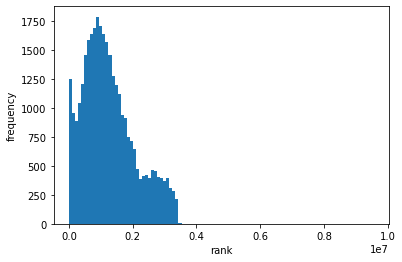

In [211]:
plt.hist(metadata['rank_num'], bins=100)
plt.xlabel("rank")
plt.ylabel("frequency")
plt.show()

In [298]:
# target_rank = ['rank_num'].tolist()[0]
# print('%s \'s rank: %s' % (target_item, target_rank))

def find_first_gte_q(v, metadata_column_name = 'rank_num'):
    for q in np.arange(0.0, 1.0, 0.01):
        if metadata[metadata_column_name].quantile(q) >= v:
            return q
    return -1

test_items = ['B01E7UKR38','B01E7UKR38','B01DDQXRWU','B01CTQC9J2','B01CTQC9J2','B01CTQC9J2','B01GW09XRW','B0195R1FT8','B016YROO36','B01E54U1RI','B01E54U1RI','B018WCT01C','B01FWP41H0','B01FWP41H0','B01GK8P0CS','B01GK8P0CS','B01F1Y2YSK','B01BI8YFAS','B01ES87TOY','B01ES87TOY','B01CRSWZAU','B01CRSWZAU','B01HC6G4D6','B01CT5SNQQ','B01CT5SNQQ','B01D8BV4VG','B0178H2LK4','B01D575H1G','B017I6B6GK','B01GOSELHE','B01GOSELHE','B01GOSELHE','B01FDO0GNI','B01G00BHN2','B01F47TKXQ','B01CWJHZW2','B01DTU7YNI','B01HFT13NG','B01FT94H1Y','B01CGPN2D8','B01CGPN2D8','B01CGPN2D8','B01DL7KJ04','B01FNIZH6A','B01FNIZH6A','B01GAFCQOQ','B01GAFCQOQ','B01GAFCQOQ','B01GAFCQOQ']
print('測試資料的 rank 百分位數，大部分連 0.5，都不到，表示：若擴大 k 後，用 rank 做為篩選排序推薦效果有限')
for item in test_items:
    metadata_column_name = 'rank_num'
    found_list = metadata[metadata['asin'] == item][metadata_column_name].tolist()
    if len(found_list) > 0:
        q = find_first_gte_q(found_list[0], metadata_column_name)
        print('%s \'s rank %s and quantile is %s' % (item, found_list[0], q))
    else:
        print('can\'t not find in meta: %s ' % item)

print('測試資料的 price 百分位數大部分 0.1~0.2，表示：若擴大 k 後，用可以選用 低價做為篩選排序')
for item in test_items:
    metadata_column_name = 'price_num'
    found_list = metadata[metadata['asin'] == item][metadata_column_name].tolist()
    if len(found_list) > 0:
        q = find_first_gte_q(found_list[0], metadata_column_name)
        print('%s \'s price %s and quantile is %s' % (item, found_list[0], q))
    else:
        print('can\'t not find in meta: %s ' % item)

測試資料的 rank 百分位數，大部分連 0.5，都不到，表示：若擴大 k 後，用 rank 做為篩選排序推薦效果有限
B01E7UKR38 's rank 306101 and quantile is 0.11
B01E7UKR38 's rank 306101 and quantile is 0.11
B01DDQXRWU 's rank 177624 and quantile is 0.07
B01CTQC9J2 's rank 123447 and quantile is 0.05
B01CTQC9J2 's rank 123447 and quantile is 0.05
B01CTQC9J2 's rank 123447 and quantile is 0.05
B01GW09XRW 's rank 5873 and quantile is 0.02
B0195R1FT8 's rank 20807 and quantile is 0.02
B016YROO36 's rank 27286 and quantile is 0.02
B01E54U1RI 's rank 56863 and quantile is 0.03
B01E54U1RI 's rank 56863 and quantile is 0.03
B018WCT01C 's rank 60004 and quantile is 0.03
B01FWP41H0 's rank 56959 and quantile is 0.03
B01FWP41H0 's rank 56959 and quantile is 0.03
B01GK8P0CS 's rank 310184 and quantile is 0.11
B01GK8P0CS 's rank 310184 and quantile is 0.11
B01F1Y2YSK 's rank 1461819 and quantile is 0.66
B01BI8YFAS 's rank 20167 and quantile is 0.02
B01ES87TOY 's rank 66688 and quantile is 0.03
B01ES87TOY 's rank 66688 and quantile is 0.03
B01CRSWZAU 

164773    $11.25
164774    $11.25
164775    $11.25
164776    $11.25
164777    $11.25
           ...  
164988    $11.25
164989    $11.25
164990    $11.25
164991    $11.25
164992    $11.25
Name: price, Length: 220, dtype: object